# Link data
https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation

In [1]:
""" Tóm tắt dữ liệu
------ Netflix Prize ------
combined_data: -> train data
MovieID:
CustomerID1,Rating1,Date1
CustomerID2,Rating2,Date2

### movie_titles:
MovieID,YearOfRelease,Title

### qualifying: -> predict data
MovieID:
CustomerID1,Date1
CustomerID2,Date2

### probe: -> giống với qualifying (nhưng không có date)
MovieID: 
CustomerID1
CustomerID2
"""
print()

# MODEL:
<pre>
Input:<br>
MovieID,CustomerID<br>
Output:<br>
Rating

# Import các thư viện cần thiết

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

In [3]:
from surprise import SVD, SVDpp, NMF # matrix factorization
from surprise import SlopeOne # slope one
from surprise import KNNBaseline, KNNWithMeans, KNNBasic # KNN
from surprise import CoClustering # co clustering
from surprise import BaselineOnly, NormalPredictor # baseline and random

from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from scipy.sparse import csr_matrix

In [4]:
path = './dataset/'
#path = './'

In [5]:
n = 1 # n là số file sẽ sử dụng, có giá trị là {1,2,3,4}

df = pd.read_csv(path+'combined_data.txt', 
                header = None, 
                names = ['Cust_Id', 'Rating'], 
                usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)


In [6]:
print('data shape: {}'.format(df.shape))
df

data shape: (24058263, 2)


,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


# Trực quan hóa dữ liệu

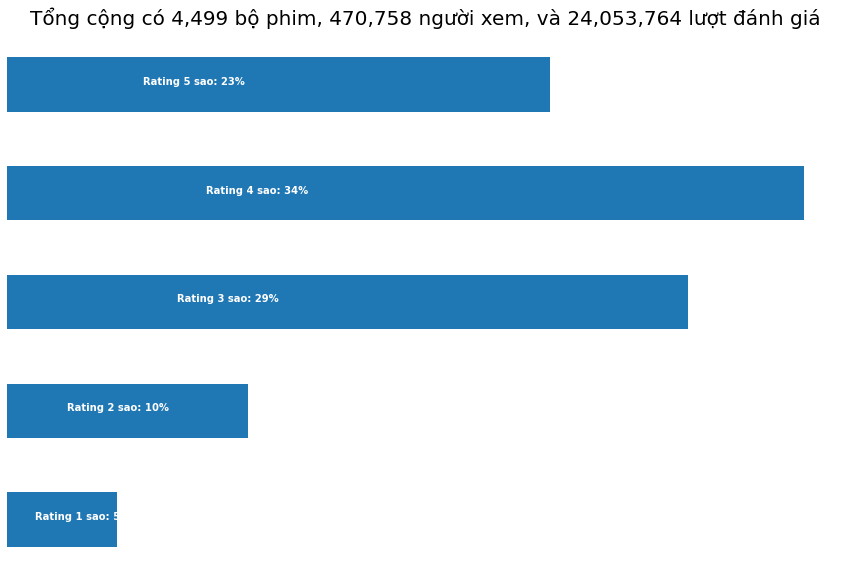

In [7]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# đếm số bộ phim có trong dữ liệu
movie_count = df.isnull().sum()[1]

# đếm số người xem
cust_count = df['Cust_Id'].nunique() - movie_count

# đếm số đánh giá của người xem
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Tổng cộng có {:,} bộ phim, {:,} người xem, và {:,} lượt đánh giá'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {} sao: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

# Biến đổi định dạng của dữ liệu từ txt sang csv
<pre>
MovieID1<br>
custID1,Rating1<br>
custID2,Rating2<br>
=>><br>
custID1, Rating1, MovieID1<br>
custID2, Rating2, MovieID1

In [8]:
# Lấy ra index của những chỗ rating là Nan vì đó là vị trí của ID phim
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [9]:
movie_np = []
movie_id = 1
# từng cặp khoảng giá trị trong df_nan trên và dưới
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # ví dụ khoảng [0:548] set movie id = 1 và tăng lên sau mỗi vòng lặp
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1 #  MovieIDs range from 1 to 17770 sequentially (trong README)
# thêm MovieID cuối cùng vào trong dữ mảng movie_np
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [ ]:
# xóa các dòng chứa MovieID (vì MovieID này vẫn còn nằm trong Cust_Id)
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

# Xử lý dữ liệu

Do data quá lớn nên loại bỏ bớt những phần không ảnh hưởng nhiều như:
- bỏ bớt movie với ít review (vì nó giành được sự quan tâm lớn của người xem)
- bỏ những customer với ít đánh giá (vì nó ít ảnh hưởng, do những người này không xem nhiều phim nên không dựa vào đó để gợi ý cho người xem nhiều phim được)<br>

Note: việc bỏ hay để do mình tự xem xét

Phân vị (quatile): có chức năng là khi cho vào 1 mảng các giá trị, hàm này sẽ thực hiện lấy độ dài của mảng nhân cho p (1>p>0) và trả về vị trí của phân vị tại p <br>
ví dụ ra có mảng [5,3,4,2,1] với p=0.5 truyền vào hàm sẽ chuyển thành [1,2,3,4,5] sau đó tính phân vị (5+1)*0.5 = 3, vị trí thứ 3 là số 3

In [11]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7), 0) # điểm phân vị (cut points)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index # lấy ra những bộ phim có số lượt rating thấp để loại bỏ 

print('Điểm phân vị trong danh sách các bộ phim: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0) # điểm phân vị (cut points)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index # lấy ra những người xem có số lần rating thấp để loại bỏ 

print('Điểm phân vị trong danh sách người xem: {}'.format(cust_benchmark))

Điểm phân vị trong danh sách các bộ phim: 1799.0
Điểm phân vị trong danh sách người xem: 52.0


Thu gọn data

In [12]:
print('Shape trước khi remove: {}'.format(df.shape))

df = df[~df['Movie_Id'].isin(drop_movie_list)] # ~ is in = not in
df = df[~df['Cust_Id'].isin(drop_cust_list)]   # ~ is in = not in

print('Shape sau khi remove: {}'.format(df.shape))
df

Shape trước khi remove: (24053764, 3)
Shape sau khi remove: (17337458, 3)


,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3
...,...,...,...
24056841,520675,3.0,4496
24056842,1055714,5.0,4496
24056843,2643029,4.0,4496
24056845,1559566,3.0,4496


# Load thông tin movie

In [13]:
movie_array = []
with open(path+'movie_titles.csv', 'r') as f:
    for line in f.readlines():
        info = line.split(',')
        movie_array.append([info[0], info[1], ', '.join(info[2:]).replace('\n','')])

In [14]:
df_title = pd.DataFrame(movie_array, columns=["Movie_Id","Year", "Name"])
df_title['Movie_Id'] = df_title['Movie_Id'].astype('int64')
df_title

,Movie_Id,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


# Recommend System

Model Recommend System

In [15]:
model_dict = {
    'SVD':SVD(),
    'SVDpp':SVDpp(),
    'NMF':NMF(),
    'SlopeOne': SlopeOne(),
    'KNNBaseline': KNNBaseline(),
    'KNNWithMeans':KNNWithMeans(),
    'KNNBasic': KNNBasic(),
    'CoClustering': CoClustering(),
    'BaselineOnly': BaselineOnly(),
    'NormalPredictor': NormalPredictor()
}

## Đánh giá model bằng cross validate

Dùng 20000 dòng để đánh giá dữ liệu

In [16]:
reader = Reader()
test_range = 20000
data_test = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:test_range], reader)

Note: <br>
do các thuật toán KNN bị lỗi MemoryError: Unable to allocate ...
nên mình có thể làm như sau:
1. giảm test range còn 20 000 dòng (đang sử dụng cách này để test)
2. bỏ các thuật toán liên quan đến KNN ra

In [17]:
# ~3m cho 20 000 dòng
cross_val = {}
for model_name, model in model_dict.items():
    print(model)
    cross_val[model_name] = cross_validate(model, data_test, measures=['RMSE', 'MAE'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

<AxesSubplot:title={'center':'Validate Time'}, xlabel='Model'>

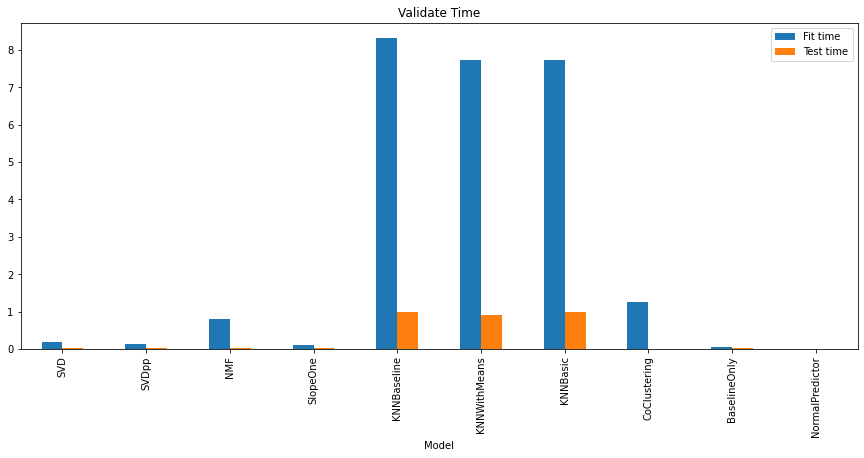

In [18]:
model_name = cross_val.keys()
validate_time = [[sum(cross_val[name]['fit_time'])/len(cross_val[name]['fit_time']),sum(cross_val[name]['test_time'])/len(cross_val[name]['test_time'])] for name in model_name]

df_model = pd.DataFrame([[name]+value for name,value in zip(list(model_name),validate_time)], columns=['Model', 'Fit time', 'Test time'])
df_model = df_model.set_index('Model', drop= True)
df_model.plot(kind="bar", figsize=(15,6), title='Validate Time')

<AxesSubplot:title={'center':'Validate Value'}, xlabel='Model'>

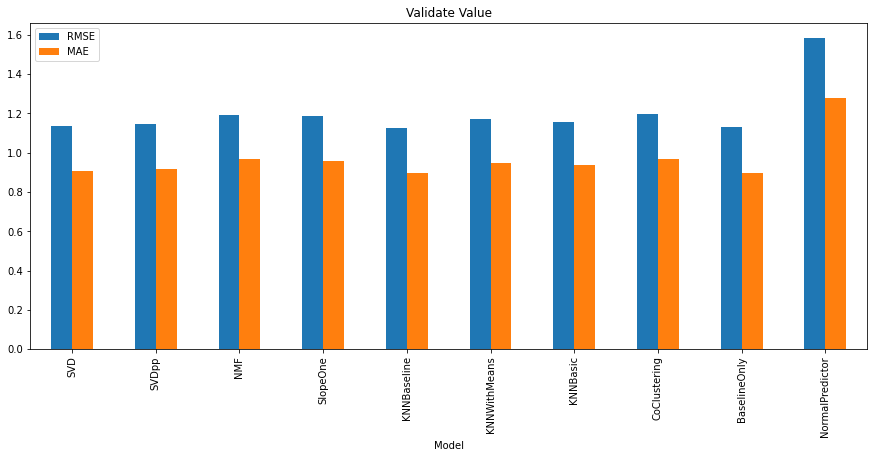

In [19]:
test_value = [[cross_val[name]['test_rmse'].mean(), cross_val[name]['test_mae'].mean()] for name in model_name]

df_model = pd.DataFrame([[name]+value for name,value in zip(list(model_name),test_value)], columns=['Model', 'RMSE', 'MAE'])
df_model = df_model.set_index('Model', drop= True)
df_model.plot(kind="bar", figsize=(15,6), title='Validate Value')

## Huấn luyện các model

Do sức mạnh phần cứng có giới hạn nên mình sẽ chỉ sử dụng 1 triệu dòng để fit cho các model

In [20]:
train_range = 1000000
data_train = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:train_range], reader)
trainset = data_train.build_full_trainset()

In [21]:
# ~1m30s cho 1 triệu dòng
for model_name in model_dict.keys():
    if model_name in ['KNNBaseline', 'KNNWithMeans','KNNBasic']:
        continue
    print(model_name)
    model_dict[model_name].fit(trainset)

SVD
SVDpp
NMF
SlopeOne
CoClustering
BaselineOnly
Estimating biases using als...
NormalPredictor


Các thuật toán KNN đều gặp 1 trường hợp lỗi là MemoryError: Unable to allocate ...<br>
Nên không thể sử dụng trong dữ liệu quá nhiều nên chúng ta sẽ làm 1 trong 2 cách
1. giảm dữ liệu còn 20 000 dòng (ảnh hưởng rất nhiều đến độ chính xác) 
2. chia dữ liệu lớn thành những phần nhỏ hơn để train lần lượt các phần  -> đang dùng cách này để demo <br>

Khuyết điểm lớn của các thuật toán dựa trên KNN là thời gian train quá lâu

In [22]:
# (cách 1)
# data_train = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:20000], reader)
# trainset = data_train.build_full_trainset()
# for model_name in ['KNNBaseline', 'KNNWithMeans','KNNBasic']:
#     print(model_name) 
#     model_dict[model_name].fit(trainset)

In [23]:
# (cách 2)
# muốn train 1 triệu dòng cho KNN thì phải tách dữ liệu ra nhiều phần để fit lần lượt từng batch (giới hạn phần cứng ở mức 20,000 dòng mỗi lần fit)
for model_name in ['KNNBaseline', 'KNNWithMeans','KNNBasic']:
    print(model_name)
    for i in range(20000, train_range, 20000):
        data_train = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][i-20000:i], reader)
        trainset = data_train.build_full_trainset()
        model_dict[model_name].fit(trainset)
        if i >= 200000: break # mình muốn giới hạn lại còn 10 lần fit (nếu muốn train hết thì bỏ dòng này đi)

KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd sim

In [24]:
def recommend(Cust_Id, Movie_Id, model):
    # Input: mã người xem, mã phim, model dự đoán
    # output: ước lượng đánh giá của ngưỡi xem với phim đó
    return model.predict(Cust_Id, Movie_Id).est

recommend(785314, 57, model_dict['SVD'])

4.04242650494424

# Load dữ liệu để predict

In [25]:
df_test = pd.read_csv(path+'qualifying.txt', 
                header = None, 
                names = ['Cust_Id', 'Date'], 
                usecols = [0,1])
df_test

,Cust_Id,Date
0,1:,NaN
1,1046323,2005-12-19
2,1080030,2005-12-23
3,1830096,2005-03-14
4,368059,2005-05-26
...,...,...
2834596,1363704,2005-10-01
2834597,9999:,NaN
2834598,2153561,2005-11-15
2834599,1490137,2005-12-22


In [26]:
df_nan = pd.DataFrame(pd.isnull(df_test.Date))
df_nan = df_nan[df_nan['Date'] == True]
df_nan = df_nan.reset_index()
df_nan

,index,Date
0,0,True
1,54,True
2,65,True
3,95,True
4,99,True
...,...,...
17465,2834114,True
17466,2834556,True
17467,2834575,True
17468,2834591,True


In [27]:
index = 0
movie_id = [int(df_test['Cust_Id'][i].replace(':','')) for i in df_nan['index']]
movie_np = []
# từng cặp khoảng giá trị trong df_nan 
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id[index])
    movie_np = np.append(movie_np, temp)
    index += 1 
last_record = np.full((1,len(df_test) - df_nan.iloc[-1, 0] - 1),movie_id[index])
movie_np = np.append(movie_np, last_record)

In [ ]:
df_test = df_test[pd.notnull(df_test['Date'])]

df_test['Movie_Id'] = movie_np.astype(int)
df_test['Cust_Id'] = df_test['Cust_Id'].astype(int)
df_test = df_test.drop(['Date'], axis=1)

# dữ liệu trong test không có trong train thì bỏ (việc bỏ hay để do mình tự xem xét)
df_test = df_test[(df_test['Movie_Id'].isin(df['Movie_Id'].values)) & (df_test['Cust_Id'].isin(df['Cust_Id'].values))]

Ước lượng Ratting

In [29]:
def recommend_all(df, model, range):
    # dùng 100 hàng đầu để ước lượng Rating
    df_predict = df.copy()[:range]
    est = []
    for line in df_predict.values:
        est.append(recommend(line[0], line[1],model))
    df_predict['Estimate Rating'] = est
    result = df_predict.sort_values('Estimate Rating', ascending=False)
    return pd.merge(result, df_title, left_on='Movie_Id', right_on='Movie_Id', how = 'left')

In [52]:
df_shuffle  = df_test.sample(frac = 1)
range_predict = 100

In [53]:
recommend_all(df_shuffle, model_dict['SVD'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,1009762,2408,4.424597,1936,My Man Godfrey
1,2127006,1682,4.421678,1997,Absolute Power
2,1506834,167,4.273672,2004,The Chorus
3,749781,257,4.271368,1973,Charlotte's Web
4,740294,886,4.248192,2004,Ray
...,...,...,...,...,...
95,2346150,788,3.253853,1994,Clerks
96,160732,1865,3.227786,2004,Eternal Sunshine of the Spotless Mind
97,1679003,1274,3.214443,1984,At Close Range
98,1167477,290,3.154183,2004,Harold and Kumar Go to White Castle


In [54]:
recommend_all(df_shuffle, model_dict['SVDpp'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,749781,257,4.532160,1973,Charlotte's Web
1,1009762,2408,4.326808,1936,My Man Godfrey
2,22905,3917,4.208458,2004,Garden State
3,2194974,118,4.153870,1985,Rambo: First Blood Part II
4,1636337,138,4.142762,1995,Star Trek: Voyager: Season 1
...,...,...,...,...,...
95,1679003,1274,3.201436,1984,At Close Range
96,1783292,290,3.200877,2004,Harold and Kumar Go to White Castle
97,1906986,1754,3.047495,1984,Sixteen Candles
98,1131851,197,2.723441,2004,Taking Lives


In [55]:
recommend_all(df_shuffle, model_dict['NMF'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,749781,257,4.114335,1973,Charlotte's Web
1,1636337,138,3.991325,1995,Star Trek: Voyager: Season 1
2,1131851,197,3.979163,2004,Taking Lives
3,1515071,111,3.822264,2003,Duplex (Widescreen)
4,1167477,290,3.751767,2004,Harold and Kumar Go to White Castle
...,...,...,...,...,...
95,2384689,1528,3.636172,1992,Radio Flyer
96,2610715,2699,3.636172,2003,The Missing
97,1783292,290,3.223073,2004,Harold and Kumar Go to White Castle
98,2194974,118,3.221741,1985,Rambo: First Blood Part II


In [56]:
recommend_all(df_shuffle, model_dict['SlopeOne'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,749781,257,4.783682,1973,Charlotte's Web
1,2194974,118,4.048712,1985,Rambo: First Blood Part II
2,1506834,167,3.917869,2004,The Chorus
3,1636337,138,3.845675,1995,Star Trek: Voyager: Season 1
4,2503967,270,3.838968,2001,Sex and the City: Season 4
...,...,...,...,...,...
95,2610715,2699,3.636172,2003,The Missing
96,1131851,197,3.492242,2004,Taking Lives
97,1515071,111,3.437371,2003,Duplex (Widescreen)
98,763849,199,3.418150,1978,The Deer Hunter


In [57]:
recommend_all(df_shuffle, model_dict['KNNBaseline'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,1057675,658,3.740788,1991,Robin Hood: Prince of Thieves
1,1933033,3782,3.740788,1990,Flatliners
2,1906986,1754,3.740788,1984,Sixteen Candles
3,2127006,1682,3.723784,1997,Absolute Power
4,1395688,2874,3.710732,2003,Elf
...,...,...,...,...,...
95,340702,1050,3.615788,1982,Annie: Special Anniversary Edition
96,1961619,1216,3.615788,1993,Fire in the Sky
97,1898688,2252,3.615788,1992,Bram Stoker's Dracula
98,689215,2617,3.496107,2002,Ghost Ship


In [58]:
recommend_all(df_shuffle, model_dict['KNNWithMeans'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,616719,3463,3.6527,1999,10 Things I Hate About You
1,794805,2443,3.6527,1992,Like Water for Chocolate
2,1102498,3151,3.6527,2004,Napoleon Dynamite
3,1925459,2470,3.6527,1992,Wayne's World
4,1298008,1962,3.6527,2004,50 First Dates
...,...,...,...,...,...
95,22905,3917,3.6527,2004,Garden State
96,2384689,1528,3.6527,1992,Radio Flyer
97,2610715,2699,3.6527,2003,The Missing
98,2405099,919,3.6527,2002,Comedian


In [59]:
recommend_all(df_shuffle, model_dict['KNNBasic'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,616719,3463,3.6527,1999,10 Things I Hate About You
1,794805,2443,3.6527,1992,Like Water for Chocolate
2,1102498,3151,3.6527,2004,Napoleon Dynamite
3,1925459,2470,3.6527,1992,Wayne's World
4,1298008,1962,3.6527,2004,50 First Dates
...,...,...,...,...,...
95,22905,3917,3.6527,2004,Garden State
96,2384689,1528,3.6527,1992,Radio Flyer
97,2610715,2699,3.6527,2003,The Missing
98,2405099,919,3.6527,2002,Comedian


In [60]:
recommend_all(df_shuffle, model_dict['CoClustering'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,749781,257,4.826987,1973,Charlotte's Web
1,2194974,118,4.277559,1985,Rambo: First Blood Part II
2,2503967,270,4.257791,2001,Sex and the City: Season 4
3,1636337,138,4.070417,1995,Star Trek: Voyager: Season 1
4,1131851,197,3.870894,2004,Taking Lives
...,...,...,...,...,...
95,2610715,2699,3.636172,2003,The Missing
96,1506834,167,3.483025,2004,The Chorus
97,1167477,290,3.336573,2004,Harold and Kumar Go to White Castle
98,763849,199,3.193831,1978,The Deer Hunter


In [61]:
recommend_all(df_shuffle, model_dict['BaselineOnly'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,749781,257,4.158984,1973,Charlotte's Web
1,2503967,270,4.156576,2001,Sex and the City: Season 4
2,2127006,1682,4.148270,1997,Absolute Power
3,1009762,2408,4.097629,1936,My Man Godfrey
4,740294,886,4.054874,2004,Ray
...,...,...,...,...,...
95,2346150,788,3.380030,1994,Clerks
96,376614,334,3.372574,2005,The Pacifier
97,1679003,1274,3.319320,1984,At Close Range
98,1515071,111,3.203902,2003,Duplex (Widescreen)


In [62]:
recommend_all(df_shuffle, model_dict['NormalPredictor'], range_predict)

,Cust_Id,Movie_Id,Estimate Rating,Year,Name
0,740294,886,5.000000,2004,Ray
1,1418440,3333,5.000000,2004,The Village
2,2042015,4472,5.000000,2003,Love Actually
3,1529670,371,5.000000,1966,The Trouble with Angels
4,1979914,528,5.000000,2005,The Hitchhiker's Guide to the Galaxy
...,...,...,...,...,...
95,1575444,2391,1.883899,2004,Along Came Polly
96,2346150,788,1.864325,1994,Clerks
97,752897,1962,1.406558,2004,50 First Dates
98,2405099,919,1.000000,2002,Comedian
